# Countries Explorative Data Analysis (EDA)

In [66]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
import time

## Overview
The dataset used in this project contains information about all the countries in the world.
The objective of the analysis is to gain insights about different details such as population, area and distribution of wealth.

## Questions for Analysis

#### Population
1. What are the 10 most populated countries?
2. What are the top 2 most populated countries by continent?
3.  What is the most populated continent?
#### Area
4. What are the top 20 largest countries?
5. What are the top 2 largest countries by continent?
6. What is the largest continent?
#### Driving Side
7. What is the proportion of countries driving on the left vs. right side?
8. What are the countries driving on the left side?
#### Languages
9. What are the top 5 most common languages?
#### Distribution of Wealth
10. What are the 10 countries with the most inequalities?
11. What is the average GINI Index by continent?
12. Is there a correlation between the GDP per capita and the GINI Index?

## About Dataset

The dataset contains information about all the 250 delegations in the world. The datasetcomes from a REST API and a dataset downloaded from a website
- [REST Countries API](https://restcountries.com/)
- [World Bank Group](https://datacatalog.worldbank.org/search/dataset/0038130)

### Columns description
- ```name``` country name
- ```code``` ISO 3166 country code
- ```continent``` continent of the country
- ```area``` country area, in $km^{2}$
- ```car_side``` left- or right-hand traffic
- ```population``` population of the country
- ```gini``` GINI Coefficient or GINI Index. It measures inequality on a scale from 0 to 1, 0 being perfect equality and 1 being perfect inequality.
- ```languages``` languages spoken
- ```gdp``` Gross Domestic Product (GDP), in millions of US Dollars

## Data Collection

### Create CSV file from API

In [9]:
# Handle ChunkedEncodingError by adding 'try except' and adding 1 second pause between each attempt
for attempt in range(5):
    country_list = []
    
    try:
        response = requests.get('https://restcountries.com/v3.1/all')
        
        if response.status_code != 200:
            print('Failed to find data')

        countriesJson = json.loads(response.content)

        # Collect relevant columns
        for item in countriesJson:
            keys = item.keys()
            country = {
                'name': item['name']['common'],
                'cca3': item['cca3'],
                'continent' : item['continents'][0],
                'area': item['area'],
                'car_side': item['car']['side'],
                'population': item['population'],
                'gini': list(item['gini'].values())[0] if 'gini' in keys else None,
                'languages': ', '.join(list(item['languages'].values())) if 'languages' in keys else None
            }
            country_list.append(country)

        header = country_list[0].keys()

        # Create/replace CSV file
        with open('Data/countries.csv', 'w', newline='') as output_file:
            dict_writer = csv.DictWriter(output_file, header)
            dict_writer.writeheader()
            dict_writer.writerows(country_list)
            output_file.close()
            print('CSV file', output_file.name, 'created')
    
        break
    except requests.exceptions.ChunkedEncodingError:
        time.sleep(1)
else:
    print('Failed to fetch data from REST countries API')

CSV file Data/countries.csv created


### Create dataframe from the 2 CSV files

In [11]:
# Get number of rows/columns of each dataframe
countries = pd.read_csv('Data/countries.csv')
print('Countries shape:', countries.shape)

gdp = pd.read_csv('Data/GDP.csv', on_bad_lines='error')
print('GDP shape:', gdp.shape)

Countries shape: (250, 8)
GDP shape: (217, 4)


In [12]:
# Merge dataframes
countries = countries.merge(right=gdp, how='left', left_on='cca3', right_on='code')
print('Merged dataframe shape:', countries.shape)

Merged dataframe shape: (250, 12)


## Data Exploration

In [14]:
countries.head()

,name,cca3,continent,area,car_side,population,gini,languages,code,rank,country,gdp
0,South Georgia,SGS,Antarctica,3903.0,right,30,NaN,English,NaN,NaN,NaN,NaN
1,Grenada,GRD,North America,344.0,left,112519,NaN,English,GRD,193.0,Grenada,"1,320"
2,Switzerland,CHE,Europe,41284.0,right,8654622,33.1,"French, Swiss German, Italian, Romansh",CHE,20.0,Switzerland,"884,940"
3,Sierra Leone,SLE,Africa,71740.0,right,7976985,35.7,English,SLE,169.0,Sierra Leone,"3,810"
4,Hungary,HUN,Europe,93028.0,right,9749763,29.6,Hungarian,HUN,56.0,Hungary,"212,389"


In [15]:
countries.tail()

,name,cca3,continent,area,car_side,population,gini,languages,code,rank,country,gdp
245,Belgium,BEL,Europe,30528.0,right,11555997,27.2,"German, French, Dutch",BEL,23.0,Belgium,"632,217"
246,Israel,ISR,Asia,20770.0,right,9216900,39.0,"Arabic, Hebrew",ISR,28.0,Israel,"509,901"
247,New Zealand,NZL,Oceania,270467.0,left,5084300,NaN,"English, Māori, New Zealand Sign Language",NZL,51.0,New Zealand,"253,466"
248,Nicaragua,NIC,North America,130373.0,right,6624554,46.2,Spanish,NIC,127.0,Nicaragua,"17,829"
249,Anguilla,AIA,North America,91.0,left,13452,NaN,English,NaN,NaN,NaN,NaN


In [16]:
countries.sample(5)

,name,cca3,continent,area,car_side,population,gini,languages,code,rank,country,gdp
210,Martinique,MTQ,North America,1128.0,right,378243,NaN,French,NaN,NaN,NaN,NaN
224,Belize,BLZ,North America,22966.0,right,397621,53.3,"Belizean Creole, English, Spanish",BLZ,174.0,Belize,"3,282"
213,Gambia,GMB,Africa,10689.0,right,2416664,35.9,English,GMB,182.0,"Gambia, The","2,340"
13,Indonesia,IDN,Asia,1904569.0,left,273523621,38.2,Indonesian,IDN,16.0,Indonesia,"1,371,171"
21,South Africa,ZAF,Africa,1221037.0,left,59308690,63.0,"Afrikaans, English, Southern Ndebele, Northern...",ZAF,40.0,South Africa,"377,782"


In [17]:
countries.dtypes

name           object
cca3           object
continent      object
area          float64
car_side       object
population      int64
gini          float64
languages      object
code           object
rank          float64
country        object
gdp            object
dtype: object

In [18]:
countries.describe()

,area,population,gini,rank
count,2.500000e+02,2.500000e+02,167.000000,206.000000
mean,6.005848e+05,3.111089e+07,38.165269,104.067961
std,1.909805e+06,1.296673e+08,7.909343,60.319921
min,4.400000e-01,0.000000e+00,24.600000,1.000000
25%,1.194250e+03,2.210995e+05,32.750000,52.250000
50%,6.492950e+04,4.912244e+06,36.800000,103.500000
75%,3.727260e+05,1.902577e+07,42.500000,156.750000
max,1.709824e+07,1.402112e+09,63.000000,208.000000


In [19]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        250 non-null    object 
 1   cca3        250 non-null    object 
 2   continent   250 non-null    object 
 3   area        250 non-null    float64
 4   car_side    250 non-null    object 
 5   population  250 non-null    int64  
 6   gini        167 non-null    float64
 7   languages   249 non-null    object 
 8   code        215 non-null    object 
 9   rank        206 non-null    float64
 10  country     215 non-null    object 
 11  gdp         215 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 23.6+ KB


## Data Preparation

In [21]:
# Drop the name column of the second and third dataframe
countries = countries.drop('country', axis=1).rename(columns={'name_x': 'name'})
countries.sample(5)

,name,cca3,continent,area,car_side,population,gini,languages,code,rank,gdp
206,Seychelles,SYC,Africa,452.0,left,98462,32.1,"Seychellois Creole, English, French",SYC,184.0,"2,141"
32,Solomon Islands,SLB,Oceania,28896.0,left,686878,37.1,English,SLB,189.0,"1,631"
133,Haiti,HTI,North America,27750.0,right,11402533,41.1,"French, Haitian Creole",HTI,122.0,"19,851"
147,Guinea,GIN,Africa,245857.0,right,13132792,33.7,French,GIN,114.0,"23,612"
50,Niger,NER,Africa,1267000.0,right,24206636,34.3,French,NER,129.0,"16,819"


In [22]:
# Drop the code column of the second dataframe
countries = countries.drop('code', axis=1).rename(columns={'cca3': 'code'})
countries.sample(5)

,name,code,continent,area,car_side,population,gini,languages,rank,gdp
99,Iraq,IRQ,Asia,438317.0,right,40222503,29.5,"Arabic, Aramaic, Sorani",52.0,"250,843"
105,Malaysia,MYS,Asia,330803.0,left,32365998,41.1,"English, Malay",37.0,"399,649"
20,Burundi,BDI,Africa,27834.0,right,11890781,38.6,"French, Kirundi",178.0,"2,642"
129,Dominica,DMA,North America,751.0,left,71991,NaN,English,199.0,654
226,Bhutan,BTN,Asia,38394.0,left,771612,37.4,Dzongkha,177.0,"2,898"


In [23]:
# Drop the rank column of the second dataframe
countries = countries.drop('rank', axis=1)
countries.sample(5)

,name,code,continent,area,car_side,population,gini,languages,gdp
165,Guyana,GUY,South America,214969.0,left,786559,45.1,English,"16,786"
152,Czechia,CZE,Europe,78865.0,right,10698896,25.0,"Czech, Slovak","330,858"
57,North Korea,PRK,Asia,120538.0,right,25778815,NaN,Korean,
49,Finland,FIN,Europe,338424.0,right,5530719,27.3,"Finnish, Swedish","300,187"
52,Tokelau,TKL,Oceania,12.0,left,1411,NaN,"English, Samoan, Tokelauan",NaN


In [24]:
# Remove whitespaces from string columns
countries['name'] = countries['name'].str.strip()
countries['code'] = countries['code'].str.strip()
countries['continent'] = countries['continent'].str.strip()
countries['car_side'] = countries['car_side'].str.strip()
countries.sample(5)

,name,code,continent,area,car_side,population,gini,languages,gdp
124,Argentina,ARG,South America,2780400.0,right,45376763,42.9,"Guaraní, Spanish","640,591"
62,Greece,GRC,Europe,131990.0,right,10715549,32.9,Greek,"238,206"
84,Madagascar,MDG,Africa,587041.0,right,27691019,42.6,"French, Malagasy","16,032"
182,Central African Republic,CAF,Africa,622984.0,right,4829764,56.2,"French, Sango","2,555"
79,Mayotte,MYT,Africa,374.0,right,226915,NaN,French,NaN


In [25]:
# Convert gdp column to float, NaN if empty
countries['gdp'] = countries['gdp'] \
    .str.replace(',', '') \
    .replace(r'^\s*$', np.nan, regex=True) \
    .astype('float')

In [143]:
# Inspect data after cleaning
countries.dtypes

name               object
code               object
continent          object
area              float64
car_side           object
population          int64
gini              float64
languages          object
gdp               float64
gdp_per_capita    float64
dtype: object

In [45]:
# Remove rows with null gini and gdp values
countries = countries.dropna(subset=['gini', 'gdp'])

In [47]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163 entries, 2 to 248
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        163 non-null    object 
 1   code        163 non-null    object 
 2   continent   163 non-null    object 
 3   area        163 non-null    float64
 4   car_side    163 non-null    object 
 5   population  163 non-null    int64  
 6   gini        163 non-null    float64
 7   languages   163 non-null    object 
 8   gdp         163 non-null    float64
dtypes: float64(3), int64(1), object(5)
memory usage: 12.7+ KB


In [49]:
countries.describe()

,area,population,gini,gdp
count,1.630000e+02,1.630000e+02,163.000000,1.630000e+02
mean,7.707521e+05,4.599960e+07,38.153374,6.192347e+05
std,2.065099e+06,1.586424e+08,7.942372,2.623345e+06
min,2.100000e+01,1.083400e+04,24.600000,6.200000e+01
25%,3.498550e+04,2.816222e+06,32.750000,1.504100e+04
50%,1.636100e+05,1.011012e+07,36.800000,4.927300e+04
75%,5.811835e+05,3.291906e+07,42.350000,3.369505e+05
max,1.709824e+07,1.402112e+09,63.000000,2.736094e+07


In [51]:
# Sort countries in alphabetical order and reset index
countries = countries.sort_values(by='name').reset_index(drop=True)
countries.head(5)

,name,code,continent,area,car_side,population,gini,languages,gdp
0,Albania,ALB,Europe,28748.0,right,2837743,33.2,Albanian,22978.0
1,Algeria,DZA,Africa,2381741.0,right,44700000,27.6,Arabic,239899.0
2,Angola,AGO,Africa,1246700.0,right,32866268,51.3,Portuguese,84723.0
3,Argentina,ARG,South America,2780400.0,right,45376763,42.9,"Guaraní, Spanish",640591.0
4,Armenia,ARM,Asia,29743.0,right,2963234,29.9,Armenian,24212.0


In [53]:
countries.tail()

,name,code,continent,area,car_side,population,gini,languages,gdp
158,Uzbekistan,UZB,Asia,447400.0,right,34232050,35.3,"Russian, Uzbek",90889.0
159,Vanuatu,VUT,Oceania,12189.0,right,307150,37.6,"Bislama, English, French",1126.0
160,Vietnam,VNM,Asia,331212.0,right,97338583,35.7,Vietnamese,429717.0
161,Zambia,ZMB,Africa,752612.0,left,18383956,57.1,English,28163.0
162,Zimbabwe,ZWE,Africa,390757.0,left,14862927,50.3,"Chibarwe, English, Kalanga, Khoisan, Ndau, Nor...",26538.0


In [55]:
# Add new column named GDP per Capita (per 1,000,000 people)
countries['gdp_per_capita'] = countries['gdp'] / countries['population'] * 1000000
countries.sample(5)

,name,code,continent,area,car_side,population,gini,languages,gdp,gdp_per_capita
107,Norway,NOR,Europe,323802.0,right,5379475,27.6,"Norwegian Nynorsk, Norwegian Bokmål, Sami",485513.0,90252.859247
9,Belarus,BLR,Europe,207600.0,right,9398861,25.3,"Belarusian, Russian",71857.0,7645.288083
5,Australia,AUS,Oceania,7692024.0,left,25687041,34.4,English,1723827.0,67108.819579
7,Azerbaijan,AZE,Europe,86600.0,right,10110116,26.6,Azerbaijani,72356.0,7156.792266
90,Mauritius,MUS,Africa,2040.0,left,1265740,36.8,"English, French, Mauritian Creole",14397.0,11374.373884


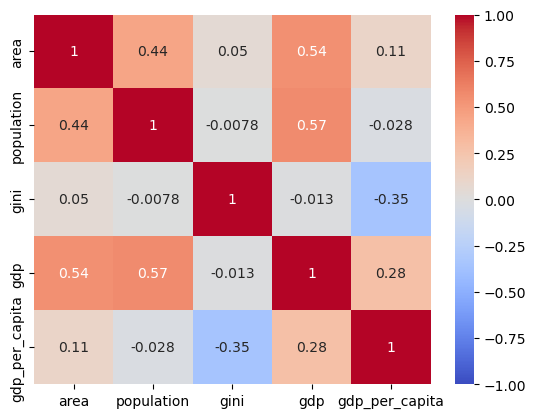

In [57]:
# Display correlation heatmap
corr_table = countries.corr(numeric_only=True)
sns.heatmap(corr_table, annot=True, cmap='coolwarm', vmin=-1)
plt.show()

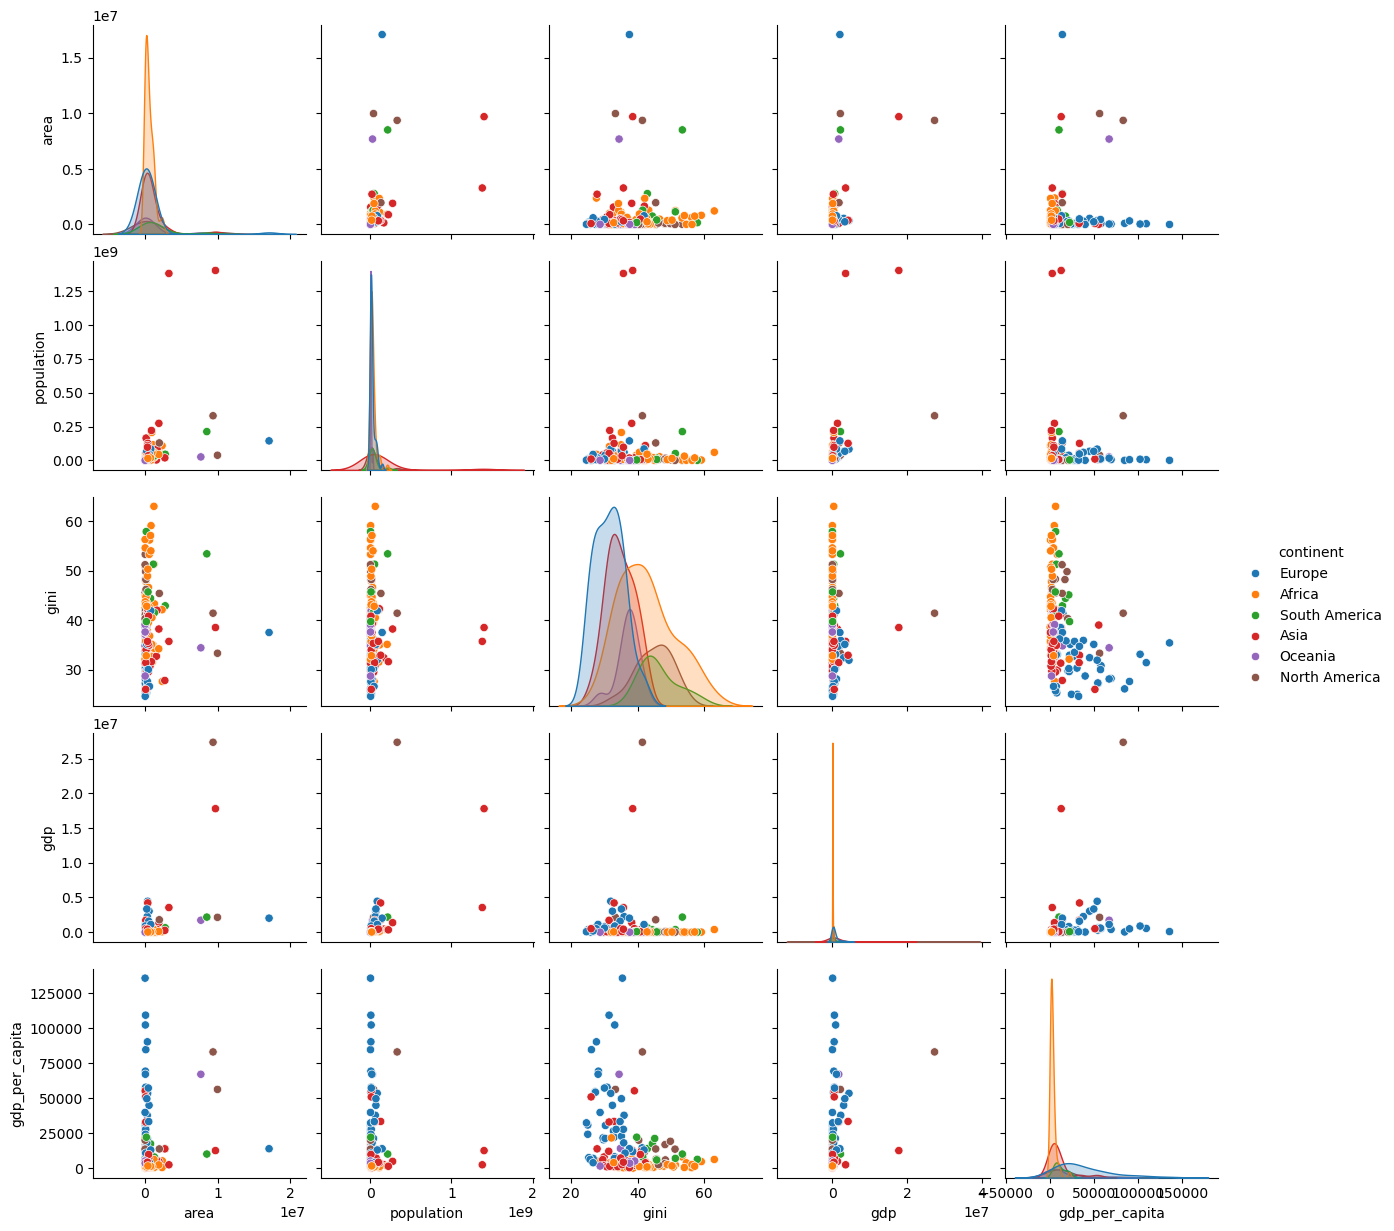

In [59]:
# Display pairplots
sns.pairplot(data=countries, hue='continent')
plt.show()

## Data Analysis

### Population

#### 1. What are the 10 most populated countries?

In [ ]:
# Data

#remove scientific notation
pd.options.display.float_format = '{:.0f}'.format 

top_10_pop_countries = countries \
    .nlargest(n=10, columns='population')[['name', 'population']] \
    .set_index('name')

top_10_pop_countries

In [ ]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_10_pop_countries,
                 x=top_10_pop_countries.index,
                 y=top_10_pop_countries['population'],
                 hue=top_10_pop_countries.index,
                 alpha=0.8)

# labels
ax.set_title('Top 10 Most Populated Countries', fontsize=18)
ax.set_xlabel('Country')
ax.set_ylabel('Population (Billions)')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', rotation=45)

# remove scientific notation showing at the top of the y axis
ax.yaxis.offsetText.set_visible(False)

plt.show()

India has surpassed China in population in April 2023 but the data is not the most recent. That's why it show China as the first.

#### 2. What are the top 2 most populated countries by continent?

In [ ]:
# Data

countries \
    .sort_values(by=['continent', 'population'], ascending=[True, False]) \
    .groupby('continent') \
    .head(2)[['continent', 'name', 'population']] \
    .reset_index(drop=True)

#### 3. What is the most populated continent?

In [ ]:
# Data

total_pop_by_continent = countries \
    .groupby('continent')[['population']] \
    .sum() \
    .sort_values(by='population', ascending=False)

total_pop_by_continent

In [ ]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=total_pop_by_continent,
                 x=total_pop_by_continent.index,
                 y=total_pop_by_continent['population'],
                 hue=total_pop_by_continent.index,
                 alpha=0.8)

# labels
ax.set_title('Total Population by Continent', fontsize=18)
ax.set_xlabel('Continent')
ax.set_ylabel('Population (Billions)')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', rotation=45)

# remove scientific notation showing at the top of the y axis
ax.yaxis.offsetText.set_visible(False)

plt.show()

The most populated continent is Asia.

### Area

#### 4. What are the top 20 largest countries?

In [ ]:
# Data

top_20_largest_countries = countries \
    .nlargest(n=20, columns='area')[['name', 'area']] \
    .set_index('name')

top_20_largest_countries

In [ ]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_20_largest_countries,
                 x=top_20_largest_countries['area'],
                 y=top_20_largest_countries.index,
                 hue=top_20_largest_countries.index,
                 alpha=0.8,
                 palette='Paired',
                 orient='h')

# labels
ax.set_title('Top 20 Largest Countries', fontsize=18)
ax.set_xlabel('Area (Tens of Millions $km^2$)')
ax.set_ylabel('Country')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)

# remove scientific notation showing at the end of the x axis
ax.xaxis.offsetText.set_visible(False)

plt.show()

#### 5. What are the top 2 largest countries by continent?

In [ ]:
# Data

countries \
    .sort_values(by=['continent', 'area'], ascending=[True, False]) \
    .groupby('continent') \
    .head(2)[['continent', 'name', 'area']] \
    .reset_index(drop=True)

#### 6. What is the largest continent?

In [ ]:
# Data

total_area_by_continent = countries \
    .groupby('continent')[['area']] \
    .sum() \
    .sort_values(by='area', ascending=False)

total_area_by_continent

The largest continent is Asia.

### Driving Side

#### 7. What is the proportion of countries driving on the left vs. right side?

In [ ]:
# Visualization
driving_sides = countries['car_side'].value_counts()
plt.pie(driving_sides, autopct='%.0f%%')
plt.title('The proportion of driving sides', fontsize=14)
plt.legend(labels=driving_sides.index.str.title())
plt.show()

#### 8. What are the countries driving on the left side?

In [ ]:
left_car_side = countries[countries['car_side'] == 'left']
left_car_side.sample(5)

In [ ]:
nb_left_side, nb_columns = left_car_side.shape

In [ ]:
left_side_english = left_car_side[left_car_side['languages'].str.contains('English')]
left_side_english.sample(5)

In [ ]:
nb_left_side_english, columns = left_side_english.shape

In [ ]:
pct_left_english = nb_left_side_english / nb_left_side
print("There are {} countries that use left-hand traffic and {:.2%} of them speak English, which makes sense since many of those countries were part of the British Empire.".format(nb_left_side, pct_left_english))

### Languages

#### 9. What are the top 5 most common languages?

In [ ]:
# Data
top_languages = countries['languages'].str.split(', ', expand=True).stack().value_counts().nlargest(n=5)
top_languages = pd.DataFrame(top_languages).rename(columns={'count': 'Number of Countries'})
top_languages

In [ ]:
# Visualization

# plot
sns.set(rc={'figure.figsize': (10, 5)})
ax = sns.barplot(data=top_languages,
                 x=top_languages.index,
                 y=top_languages['Number of Countries'],
                 hue=top_languages.index,
                 alpha=0.8,
                 palette="Set2")

# labels
ax.set_title('Top 5 Most Common Languages', fontsize=18)
ax.set_xlabel('Language')
ax.set_ylabel('Number of countries')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=12)

plt.show()

### Distribution of Wealth

#### 10. What are the 10 countries with the most inequalities?

In [ ]:
bottom_10_countries = countries.nlargest(n=10, columns='gini')[['name', 'continent', 'gini']]
bottom_10_countries

#### 11. What is the average GINI Index by continent?

In [ ]:
avg_gini_per_continent = countries \
    .groupby('continent')[['gini']] \
    .mean() \
    .sort_values(by='gini', ascending=False)
avg_gini_per_continent

In [ ]:
# Visualization of the distribution of GINI Indices by continent

# plot
flierprops = dict(marker='d', markersize=3, markerfacecolor='black')
sns.set(rc={'figure.figsize': (15, 4.5)})
ax = sns.boxplot(data=countries, x='continent', y='gini', hue='continent', flierprops=flierprops)

# labels
ax.set_title('Distribution of GINI Index per continent', fontsize=14)
ax.xaxis.label.set_size(11)
ax.yaxis.label.set_size(11)
ax.tick_params(axis='both', labelsize=9)

plt.show()

#### 12. Is there a correlation between the GDP per capita and the GINI Index?

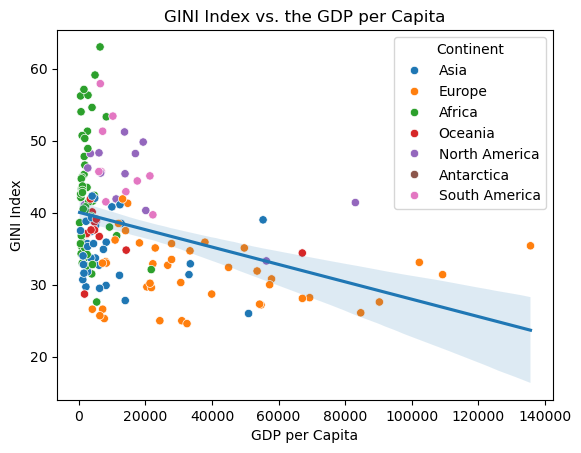

In [135]:
# Visualization

ax = sns.scatterplot(data=countries, x='gdp_per_capita', y='gini', hue='continent')
sns.regplot(data=countries, x='gdp_per_capita', y='gini', scatter=False, ax=ax)
ax.set_title('GINI Index vs. the GDP per Capita')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('GINI Index')

plt.legend(title='Continent')
plt.show()

In the data exploration phase, we saw that the correlation coefficient between the GDP per capita and the GINI Index is -0.35, which is not very strong. It's interesting to see that for European countries, the GINI Index remains stable no matter the GDP per capita, which means the wealth is distributed rather equally.

## End